<a href="https://colab.research.google.com/github/RajK853/tum-adlr-ss21-11/blob/main/notebook/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for Google Colab
The sections below are required to execute this notebook in Google Colab. If you are not executing this notebook in Google colab, you can skip these sections.

## Load Tensorflow
In Google Colab, tensorflow can be easily selected using the given magic command:

In [5]:
%tensorflow_version 2.x

## Cloning the repo
The shell command below clones the git repo if the local repo directory does not exit. Otherwise, it simply pulls the updated version.

In [3]:
%%shell
REPOSRC=https://github.com/RajK853/tum-adlr-ss21-11.git
LOCALREPO=/adlr
 
LOCALREPO_VC_DIR=$LOCALREPO/.git
 
if [ ! -d $LOCALREPO_VC_DIR ]
then
    git clone $REPOSRC $LOCALREPO
else
    cd $LOCALREPO
    git pull $REPOSRC
fi

From https://github.com/RajK853/tum-adlr-ss21-11
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


## Setting the working directory
By default, the working directory is `./notebook/` for Jupyter Lab. Therefore, we set the working directory to that path also in Google Colab so that the later cells are compatible with both Google Colab and Jupyter Lab. 

In [4]:
%cd /adlr/notebook

/adlr/notebook


## Mount Google Drive
Mount your Google drive to access the data set located in your Google drive.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Implementation
The sections below works for both Google Colab and Jupyter Notebook.

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras import utils
from sklearn.model_selection import train_test_split

CPU times: user 4.71 s, sys: 1.69 s, total: 6.4 s
Wall time: 51.6 s


In [2]:
%load_ext tensorboard

In [3]:
# Change directory to src to import functions from load.py
%cd "../src"
from models import u_dense_net
from generators import DataGen
from losses import soft_dice_loss
from load import get_values_sql, compressed2img, object2numeric_array

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/src


# Local functions

In [4]:
def load_world_data(db_path, n_voxels, n_dim):
    worlds = get_values_sql(file=db_path, table="worlds")
    obstacle_images = compressed2img(img_cmp=worlds.obst_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    return obstacle_images

def load_data(db_path, path_indexes, n_voxels, n_dim):    
    paths = get_values_sql(file=db_path, table='paths', rows=path_indexes)
    path_images = compressed2img(img_cmp=paths.path_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    start_images = compressed2img(img_cmp=paths.start_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    end_images = compressed2img(img_cmp=paths.end_img_cmp.values, n_voxels=n_voxels, n_dim=n_dim)
    
    q_paths = object2numeric_array(paths.q_path.values)
    q_paths = q_paths.reshape(-1, n_waypoints, n_dim)
    return start_images, end_images, path_images

def image2image_callback(batch_indexes, data_dict):
    path_indexes = data_dict["path_rows"][batch_indexes]
    obst_indexes = path_indexes//n_paths_per_world
    obst_batch_data = data_dict["obst_imgs"][obst_indexes]
    goal_batch_data = data_dict["goal_imgs"][batch_indexes]
    path_batch_data = data_dict["path_imgs"][batch_indexes]
    input_batch_data = [np.concatenate([obst_batch_data, goal_batch_data], axis=-1)]
    output_batch_data = [path_batch_data]
    return input_batch_data, output_batch_data

# Init global variables

In [5]:
db_path = r"../SingleSphere02.db"   # Path of the data in your local machine

n_voxels = 64
voxel_size = 10 / 64     # in m
extent = [0, 10, 0, 10]  # in m
n_waypoints = 22         # start + 20 inner points + end
n_dim = 2
n_paths_per_world = 1000
n_paths = 50000
path_rows = np.arange(0, n_paths, step=10)

batch_size = 32
validation_ratio = 0.1
input_shape = (n_voxels, n_voxels, 2)

# Load training and validation data

In [6]:
%%time
obst_imgs = load_world_data(db_path, n_voxels, n_dim)

start_imgs, end_imgs, path_imgs = load_data(db_path, path_rows, n_voxels, n_dim)
goal_imgs = start_imgs + end_imgs            # Add start and end images together
# Expand dimension of images to create the channel layer
obst_imgs, goal_imgs, path_imgs = (
    np.expand_dims(data, axis=-1) 
    for data in (obst_imgs, goal_imgs, path_imgs)
)
del start_imgs, end_imgs

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/src/load.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array([np.frombuffer(v, dtype=int) for v in value])


CPU times: user 552 ms, sys: 198 ms, total: 750 ms
Wall time: 7.85 s


In [7]:
# TODO: Use better uniform data split technique 
train_goal_imgs, validation_goal_imgs, train_path_imgs, validation_path_imgs = train_test_split(goal_imgs, path_imgs.astype("float32"), test_size=validation_ratio)
train_data_dict = {
    "path_rows": path_rows,          # This is used to 
    "obst_imgs": obst_imgs,
    "goal_imgs": train_goal_imgs,
    "path_imgs": train_path_imgs
}

validation_data_dict = {
    "path_rows": path_rows,
    "obst_imgs": obst_imgs,
    "goal_imgs": validation_goal_imgs,
    "path_imgs": validation_path_imgs
}

In [8]:
train_data_gen = DataGen(train_data_dict, callback=image2image_callback, batch_size=batch_size)
validation_data_gen = DataGen(validation_data_dict, callback=image2image_callback, batch_size=batch_size)

# Visualize Graph

In [9]:
%tensorboard --logdir "temp"

# Load U-DenseNet model

In [10]:
%cd "../notebook"
!rm -rf "temp"
tf.keras.backend.clear_session()
denseNet = u_dense_net(input_shape, num_db=5, num_channels=32, growth_rate=32, convs_per_db=3)
optimizer = tf.keras.optimizers.Adam(lr=3e-4)
denseNet.compile(optimizer=optimizer, loss=soft_dice_loss)
utils.plot_model(denseNet, show_shapes=True)    # Saves model graph as model.png
denseNet.summary()

/home/rajk/DIT/ADLR/tum-adlr-ss21-11/notebook
Model: "DenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 64, 64, 2)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   1632        image_input[0][0]                
__________________________________________________________________________________________________
dense_block (DenseBlock)        (None, 64, 64, 128)  56160       conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 64, 64, 160)  0           conv2d[0][0]                     
                                             

# Train U-DenseNet model

In [11]:
%%time
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir="temp"),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5)
]
history = denseNet.fit(train_data_gen, validation_data=validation_data_gen, epochs=100, callbacks=callbacks)

Epoch 1/100
141/141 [==============================] - 50s 352ms/step - loss: 0.5291 - val_loss: 0.9996
Epoch 2/100
141/141 [==============================] - 29s 207ms/step - loss: 0.4194 - val_loss: 0.9999
Epoch 3/100
141/141 [==============================] - 29s 207ms/step - loss: 0.3576 - val_loss: 0.8644
Epoch 4/100
141/141 [==============================] - 30s 210ms/step - loss: 0.3332 - val_loss: 0.6363
Epoch 5/100
141/141 [==============================] - 30s 212ms/step - loss: 0.3153 - val_loss: 0.5441
Epoch 6/100
141/141 [==============================] - 30s 211ms/step - loss: 0.3055 - val_loss: 0.3364
Epoch 7/100
141/141 [==============================] - 29s 207ms/step - loss: 0.2992 - val_loss: 0.3316
Epoch 8/100
141/141 [==============================] - 29s 205ms/step - loss: 0.2932 - val_loss: 0.3255
Epoch 9/100
141/141 [==============================] - 29s 205ms/step - loss: 0.2870 - val_loss: 0.3085
Epoch 10/100
141/141 [==============================] - 29s 208m

# Load testing data

In [12]:
test_path_rows = np.arange(n_paths, n_paths+5000, step=100)
test_start_imgs, test_end_imgs, test_path_imgs = load_data(db_path, test_path_rows, n_voxels, n_dim)
test_goal_imgs = test_start_imgs + test_end_imgs
test_goal_imgs, test_path_imgs = (
    np.expand_dims(data, axis=-1) 
    for data in (test_goal_imgs, test_path_imgs)
)
del test_start_imgs, test_end_imgs

In [13]:
world_indexes = test_path_rows//n_paths_per_world
test_data = np.concatenate([obst_imgs[world_indexes], test_goal_imgs], axis=-1)
out_data = denseNet.predict(test_data)

# Visualize on test data

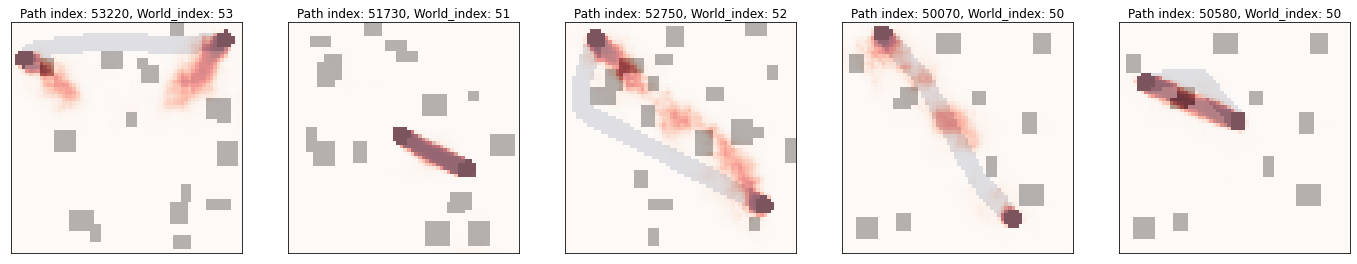

In [14]:
N = 5
path_indexes = np.random.choice(test_path_rows, size=N)
_, axs = plt.subplots(nrows=1, ncols=N, figsize=((1+N)*4, 10))
for path_i, ax in zip(path_indexes, axs):
    i = np.where(test_path_rows==path_i)[0].item()
    obst_img = obst_imgs[path_i//n_paths_per_world]
    test_goal_img = test_goal_imgs[i]
    test_path_img = test_path_imgs[i]

    ax.imshow(obst_img[:, :, 0], origin='lower', extent=extent, cmap='binary')
    ax.imshow(test_goal_img[:, :, 0], origin='lower', extent=extent, cmap='Greens', alpha=0.25)
    ax.imshow(test_path_img[:, :, 0], origin='lower', extent=extent, cmap='Blues', alpha=0.25)
    ax.imshow(out_data[i, :, :, 0], origin='lower', extent=extent, cmap='Reds', alpha=0.5)
    ax.set_title(f"Path index: {path_i}, World_index: {path_i//n_paths_per_world}")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# TODOs
1. Save trained model
2. Save prediction images from intermediate models